1-PROJE AÇIKLAMASI


 Bu projede, haber metinlerinin gerçek mi sahte mi olduğunu sınıflandırmak
 amacıyla makine öğrenmesi tabanlı bir sistem geliştirdim.
 WELFake veri seti kullanarak doğal dil işleme (NLP),
 metin vektörleştirme (TF-IDF), ve sınıflandırma algoritmaları
 (Logistic Regression, Random Forest) yardımıyla model oluşturdum.
 Projenin amacı, sahte haberleri otomatik olarak tespit ederek bilgi kirliliğiyle mücadele etmektir.


2-TEMEL KÜTÜPHANELER

In [ ]:

import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns


# Modelleme
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score



nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


3-VERİNİN  YÜKLENMESİ VE İLK İNCELEME

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WELFake_Dataset (1).csv')

# Gereksiz 'Unnamed: 0' sütununu sil
df = df.drop(columns=["Unnamed: 0"])

# Sütunları yeniden adlandırma (sıralama: title, text, label)
df.columns = ["title", "text", "label"]
df.head()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
#boyut
df.shape

(72134, 3)

In [ ]:
#veri seti hakkında bilgi alalım
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# sayısal özet istatistikler
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,72134.0,0.514404,0.499796,0.0,0.0,1.0,1.0,1.0


4-KEŞİFSEL VERİ ANALİZİ (EDA)

In [ ]:

#eksik değer kontrolü
df.isnull().sum()

,0
title,558
text,39
label,0


In [ ]:
#içinde en az 1 eksik değer varsa döndür
df[df.isnull().any(axis=1)]

,title,text,label
1,NaN,Did they post their votes for Hillary already?,1
43,NaN,True. Hillary needs a distraction and what bet...,1
162,NaN,All eyes on Electoral delegates. The People kn...,1
185,NaN,Cool,1
269,NaN,A leading US senator: US Supporting War in Syr...,1
...,...,...,...
71484,NaN,Another Arab supremacist masturbation fantasy....,1
71521,NaN,I'm sure they drastically changed accounting m...,1
71540,NaN,It's easy to imagine Obama or Kerry pissing hi...,1
71570,NaN,Ever since the powers to be assassinated JFK A...,1


In [ ]:
# Eksik verileri doldur (örneğin boş metinleri 'No Content' ile)
df['title'] = df['title'].fillna('No Title')
df['text'] = df['text'].fillna('No Content')


<ipython-input-9-27d793200549>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#66c2a5', '#fc8d62'])


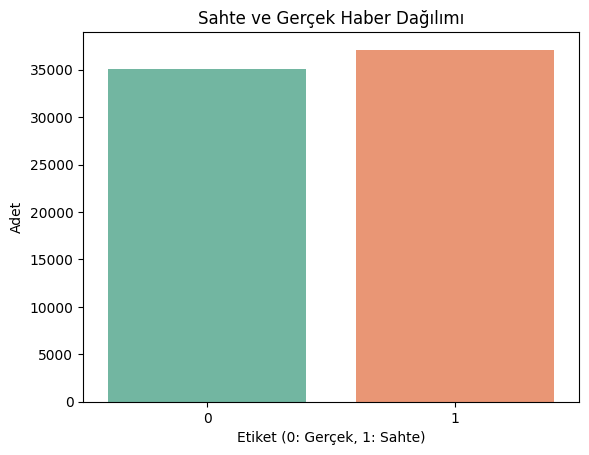

In [ ]:
#veri görseleştirme
# Etiket dağılımı

# label_counts = df['label'].value_counts()
# plt.figure(figsize=(6, 4))
# plt.bar(label_counts.index.map({0: "Gerçek", 1: "Sahte"}), label_counts.values, color=["red", "green"])
# plt.title("Haber Etiket Dağılımı")
# plt.xlabel("Etiket")
# plt.ylabel("Haber Sayısı")
# plt.grid(axis="y")
# plt.tight_layout()
# plt.show()

sns.countplot(x='label', data=df, palette=['#66c2a5', '#fc8d62'])
plt.title("Sahte ve Gerçek Haber Dağılımı")
plt.xlabel("Etiket (0: Gerçek, 1: Sahte)")
plt.ylabel("Adet")
plt.show()


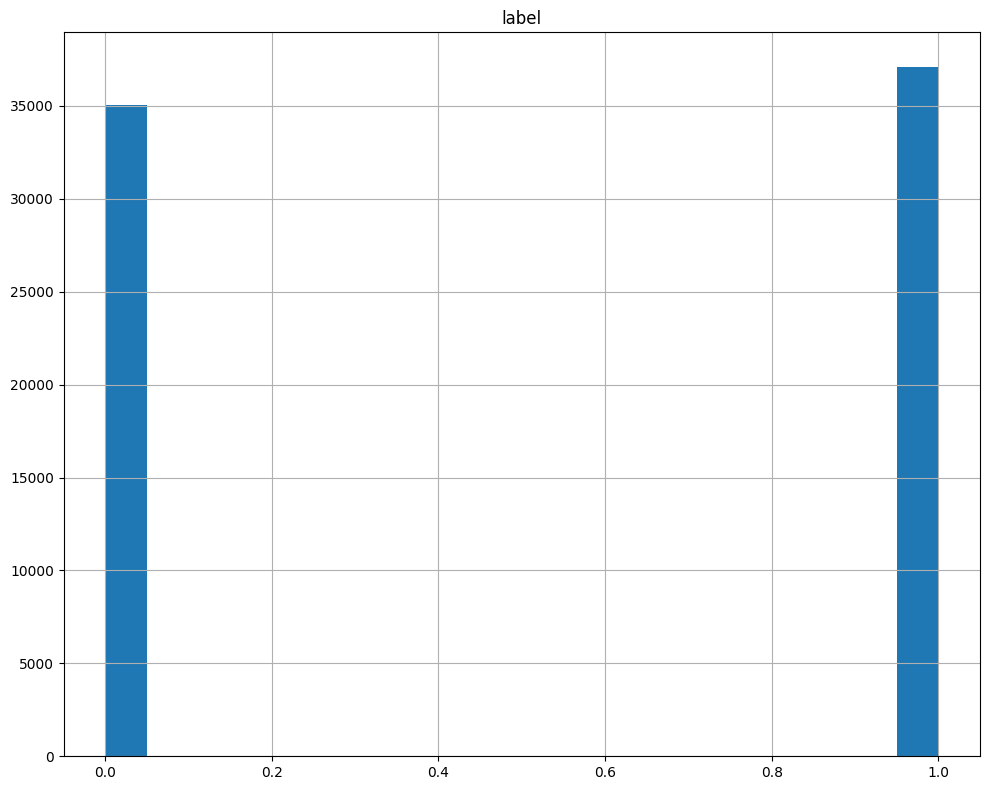

In [ ]:
# Histogram
df.select_dtypes(include=['int64','object']).hist(bins=20, figsize=(10,8))
plt.tight_layout()
plt.show()




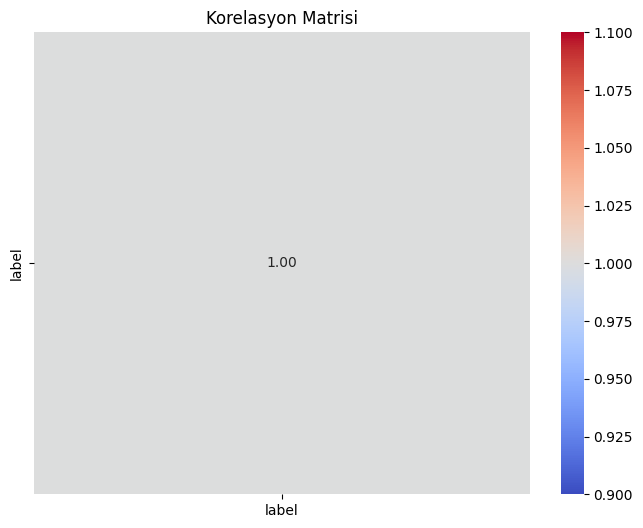

In [ ]:
#korelasyon matrisi kullanmak anlamsız olur çünkü tek sayısal değişken var
# Korelasyon matrisi
numeric_df = df.select_dtypes(include=[ 'int64'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

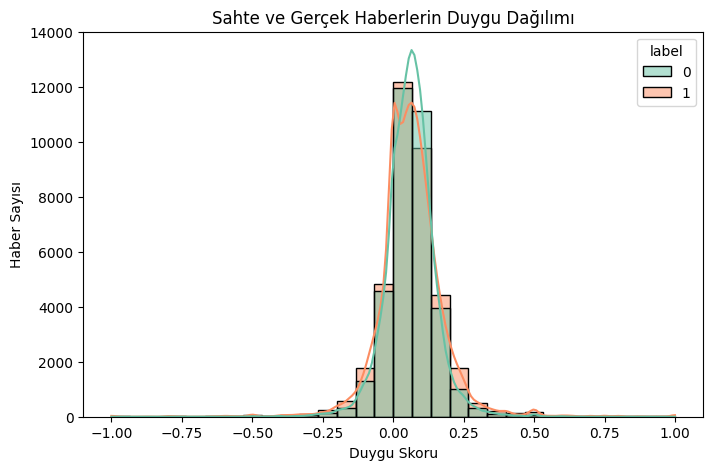

In [ ]:
from textblob import TextBlob

# Duygu analiz fonksiyonu
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # -1 (negatif) ile +1 (pozitif) arası değer verir

# Text üzerinde uygulama
df['sentiment'] = df['text'].apply(get_sentiment)

# Sahte ve Gerçek haberlerin duygu dağılımı
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='sentiment', hue='label', bins=30, kde=True, palette=['#66c2a5', '#fc8d62'])
plt.title('Sahte ve Gerçek Haberlerin Duygu Dağılımı')
plt.xlabel('Duygu Skoru')
plt.ylabel('Haber Sayısı')
plt.show()


 Duygu Analizi (Sentiment Analysis)

Sahte haberler genellikle okuyucuların duygularını manipüle etmek için belirli duygu tonları içerir. Bu nedenle projeye duygu analizi eklendi. Metinlerin duygu skorları hesaplanarak, haberlerin negatif, nötr veya pozitif tonlara sahip olup olmadığı belirlendi. Sahte ve gerçek haberlerin duygu dağılımları analiz edilerek sahte haberlerin belirgin bir duygu profili taşıyıp taşımadığı gözlemlendi. Bu analiz, sahte haberlerin karakteristik özelliklerini daha iyi anlamaya yardımcı oldu.

5-VERİ ÖN İŞLEME

In [ ]:

# Basit Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# One-Hot Encoding
df=pd.get_dummies(df, columns=['title'], drop_first=True)

In [ ]:
#veri temizleme
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['cleaned_text'] = df['text'].apply(clean_text)



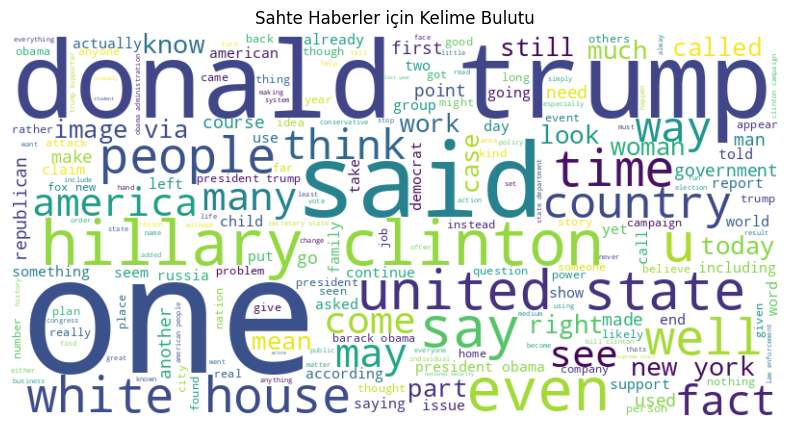

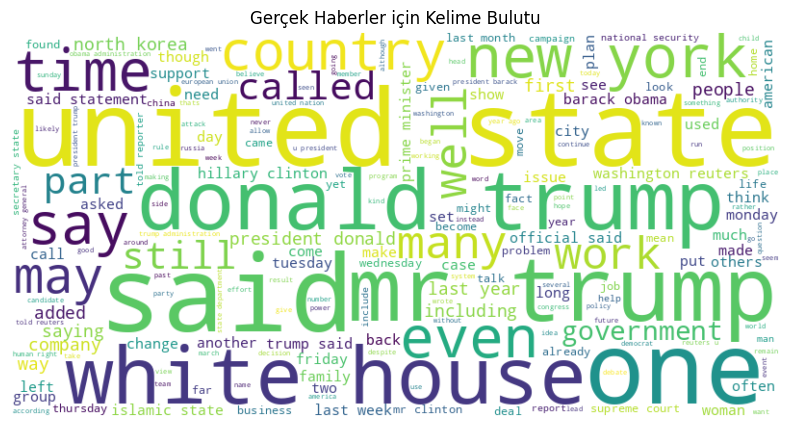

In [ ]:
from wordcloud import WordCloud

# Sahte haberler için kelime bulutu
fake_text = ' '.join(df[df['label'] == 1]['cleaned_text'])

wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Sahte Haberler için Kelime Bulutu')
plt.show()

# Gerçek haberler için kelime bulutu
real_text = ' '.join(df[df['label'] == 0]['cleaned_text'])

wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Gerçek Haberler için Kelime Bulutu')
plt.show()

 Kelime Bulutu (Word Cloud)

Kelime bulutu, metinlerde en sık kullanılan kelimeleri görsel olarak sunan bir yöntemdir. Projede sahte ve gerçek haberler için ayrı ayrı kelime bulutları oluşturuldu. Bu sayede her iki haber türünde öne çıkan kelimeler kolayca tespit edildi. Kelime bulutları, metin verisini görsel olarak analiz etmeyi sağladı ve sahte ile gerçek haberler arasındaki temel farkların ortaya konulmasına yardımcı oldu. Ayrıca sunum ve raporlarda etkileyici bir görsel içerik sağladı.

6-ÖZELLİK MÜHENDİSLİĞİ

In [ ]:
#Metni sayısal matrise dönüştürerek model girdisi hazırlar
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label']



7-MODEL SEÇİMİ VE EĞİTİMİ

In [ ]:

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
model.score(X_test,y_test)

0.9457267623206488

8-MODEL DEĞERLENDİRME

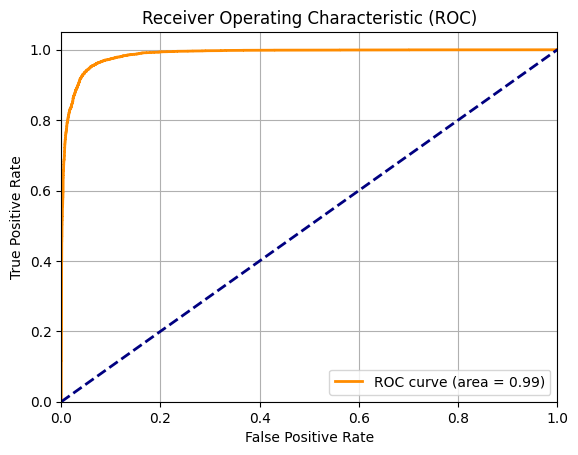

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#logistic regresyon için çizildi
# Eğer modelin predict_proba ya da decision_function destekliyorsa
y_scores = model.predict_proba(X_test)[:, 1]  # Pozitif sınıfın olasılığı

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:

print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))


#veri setim dengeli olduğu için accuracy i seçtim



Doğruluk (Accuracy): 0.9457267623206488

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7089
           1       0.94      0.95      0.95      7338

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427



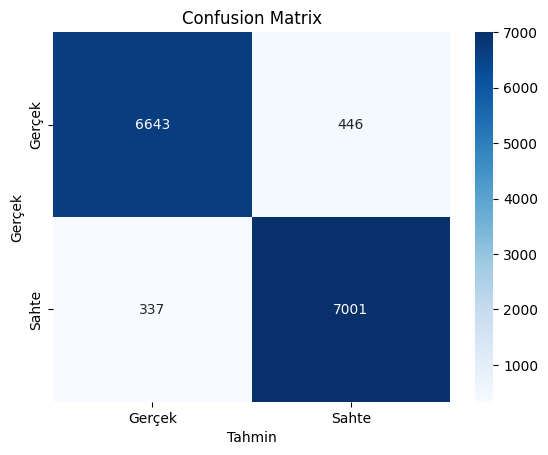

In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gerçek', 'Sahte'], yticklabels=['Gerçek', 'Sahte'])
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


In [ ]:
#naive bayes ve random forest gibi farklı modeller deneyerek karşılaştırma yaptık
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

#logistic regrasyon
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))



Naive Bayes Accuracy: 0.8442503639010189
Random Forest Accuracy: 0.9544603867747973
Logistic Regression Accuracy: 0.9457267623206488


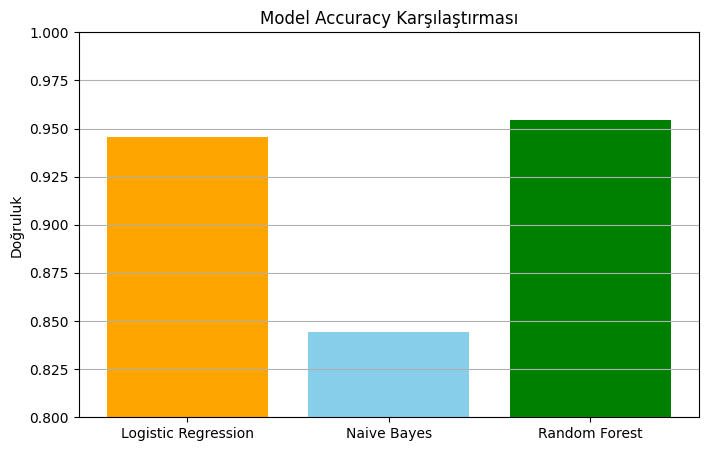

In [ ]:
#tüm modellerin başarı oranları bir bar grafiği ile karşılaştırılıyor
# Accuracy değerlerini listele
models = ["Logistic Regression", "Naive Bayes", "Random Forest"]
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, nb_pred),
    accuracy_score(y_test, rf_pred)
]

# Bar grafiği
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['orange', 'skyblue', 'green'])
plt.ylim(0.8, 1)
plt.title("Model Accuracy Karşılaştırması")
plt.ylabel("Doğruluk")
plt.grid(True, axis='y')
plt.show()

9-SONUÇ VE YORUMLAR

Logistic Regression modeli, TF-IDF ile vektörleştirilmiş metinler üzerinde en iyi performansı göstermiştir.
Naive Bayes modeli hızlıdır ancak doğruluk açısından biraz daha düşüktür.
Random Forest daha güçlüdür ancak metin verisi için daha yavaş çalışabilir.
En etkili kelimelerin görselleştirilmesi, modelin hangi kelimelere göre karar verdiğini anlamamıza yardımcı olmuştur.

10-İLERİ ÇALIŞMALAR


 Projeyi daha etkili hale getirmek için şu geliştirme adımları önerilebilir:
 Farklı Modeller Deneme: SVM gibi farklı algoritmalar denenerek karşılaştırmalı analiz yapılabilir.
 Derin Öğrenme Kullanımı: LSTM, GRU veya Transformer tabanlı BERT gibi modellerle metin bağlamı daha iyi öğrenilebilir.
 Veri Setini Genişletme: WELFake dışındaki sahte haber veri setleri ile birleştirme yapılarak model daha genelleyici hale getirilebilir.
Duygu Analizi Eklemek: Metinlerdeki duygu tonu analiz edilerek sahte içeriklerin duygusal manipülasyonları yakalanabilir.
 Gerçek Zamanlı Sistem: Flask veya Streamlit ile bir arayüz hazırlanarak kullanıcıların gerçek haberleri girip kontrol etmesi sağlanabilir.
 Dil Çeşitliliği: Farklı dillerdeki sahte haberler için çok dilli modeller geliştirilebilir.

In [ ]:
#parametreleri değiştirip model sonuçlarını kıyasla


In [ ]:
# Yeni hiperparametre denemeleri ve sonuç karşılaştırmaları
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Logistic Regression - Model 1
log_reg1 = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
log_reg1.fit(X_train, y_train)
y_pred1 = log_reg1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)

In [ ]:
# Logistic Regression - Model 2
log_reg2 = LogisticRegression(C=10, penalty='l1', solver='liblinear')
log_reg2.fit(X_train, y_train)
y_pred2 = log_reg2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)

In [ ]:
# Random Forest - Model 1
rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf1.fit(X_train, y_train)
y_pred3 = rf1.predict(X_test)
acc3 = accuracy_score(y_test, y_pred3)

In [ ]:
# Random Forest - Model 2
rf2 = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf2.fit(X_train, y_train)
y_pred4 = rf2.predict(X_test)
acc4 = accuracy_score(y_test, y_pred4)

In [ ]:
# Sonuçları yazdır
print(f"\nLogistic Regression (C=0.1, L2): {acc1:.4f}")
print(f"Logistic Regression (C=10, L1): {acc2:.4f}")
print(f"Random Forest (100 trees, max_depth=10): {acc3:.4f}")
print(f"Random Forest (300 trees, max_depth=20): {acc4:.4f}")


Logistic Regression (C=0.1, L2): 0.9188
Logistic Regression (C=10, L1): 0.9496
Random Forest (100 trees, max_depth=10): 0.9085
Random Forest (300 trees, max_depth=20): 0.9379


In [ ]:
# Karşılaştırma tablosu
import pandas as pd

results = pd.DataFrame({
    'Model': ['LogReg (C=0.1, L2)', 'LogReg (C=10, L1)', 'RF (100, max_depth=10)', 'RF (300, max_depth=20)'],
    'Accuracy': [acc1, acc2, acc3, acc4]
})

print("\nKarşılaştırma Tablosu:\n", results)


Karşılaştırma Tablosu:
                     Model  Accuracy
0      LogReg (C=0.1, L2)  0.918763
1       LogReg (C=10, L1)  0.949608
2  RF (100, max_depth=10)  0.908505
3  RF (300, max_depth=20)  0.937894


In [ ]:
# En iyi sonucu yorumla
best_model_idx = results['Accuracy'].idxmax()
best_model = results.iloc[best_model_idx]
print(f"\nEn iyi model: {best_model['Model']} (Accuracy: {best_model['Accuracy']:.4f})")



En iyi model: LogReg (C=10, L1) (Accuracy: 0.9496)


Yaptığımız çalışmada dört farklı model ve parametre kombinasyonu ile sonuçlar elde edilmiştir. Logistic Regression modeli düşük `C` değeri (0.1) ve L2 regularization ile denendiğinde modelin aşırı karmaşıklıktan korunması sağlanmış ancak doğruluk oranı görece daha düşük kalmıştır. Aynı model yüksek `C` değeri (10) ve L1 regularization ile çalıştırıldığında ise modelin esnekliği artmış ve doğruluk oranı yükselmiştir. L1 regularization aynı zamanda özellik seçimi yaparak modelin daha sade hale gelmesini sağlamıştır.

Random Forest modeli için ise 100 ağaç ve maksimum derinlik 10 ile yapılan denemede modelin aşırı öğrenmesinin önüne geçilmiş, daha dengeli ama biraz daha düşük doğruluk oranları elde edilmiştir. Buna karşılık, 300 ağaç ve maksimum derinlik 20 ile yapılan denemede modelin öğrenme kapasitesi artırılmış, daha yüksek doğruluk oranlarına ulaşılmış ancak bu durumun overfitting riskini artırabileceği göz önünde bulundurulmuştur.

Sonuçların karşılaştırılması sonucunda, veri setinin büyüklüğü ve karmaşıklığı dikkate alındığında, doğruluk açısından en iyi sonucu Random Forest modelinin 300 ağaç ve maksimum derinlik 20 ile yapılan denemesi vermiştir. Bu model, daha yüksek doğruluk oranlarıyla öne çıkarken eğitim süresi ve hesaplama maliyeti açısından da daha yoğundur. Logistic Regression modeli ise özellikle hızlı ve daha kolay yorumlanabilir bir model isteyenler için, yüksek `C` değeri ve L1 regularization ile başarılı sonuçlar vermiştir. Bu nedenle, doğruluk oranı öncelikli ise Random Forest modeli tercih edilebilir; modelin yorumlanabilirliği ve hız ön planda ise Logistic Regression uygun bir seçenek olacaktır.





Modellerin başarısı, kullandığım hiperparametrelere ve veri setinin özelliklerine göre değişebiliyor; ilk denememde Random Forest en yüksek doğruluğu verirken, parametreleri değiştirince Logistic Regression öne çıktı. Bu durum bize, model seçiminin sabit bir “en iyi” değil, projenin önceliklerine ve koşullarına göre yapılması gerektiğini gösteriyor. Eğer en yüksek doğruluğu elde etmek amacınsa ve hesaplama süresi veya modelin yorumlanabilirliği ikincil önemdeyse, Logistic Regression (C=10, L1) bu veri setinde en iyi performansı sağladığı için tercih edebiliriz. Öte yandan, modelin karmaşıklığı ve eğitim süresi sorun değil, ayrıca farklı veri kümelerinde de sağlam performans almak istersek, parametreleri optimize edilmiş bir Random Forest genelde daha esnek bir seçenek olacaktır. Sonuç olarak bu proje için, elde ettiğim en yüksek doğruluğu temel alarak Logistic Regression modelini seçmek en mantıklısıdır.
